In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
from sklearn.metrics import mean_absolute_error
from src.metrics import plot_calibration_curve, weighted_average
from src.estimates import get_confidence_estimates

In [2]:
graphics_format = ".png"
graphics_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Graphics/"
tables_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Tables/"
list_of_all_models = [x for x in os.listdir("../results/scores") if not x.startswith(".")]

### Long dataframe with instance-level results

In [3]:
if os.path.isfile("../results/instance_level_results.json"):
    instance_lvl_results = pd.read_json(
        "../results/instance_level_results.json",
        orient="records",
        lines=True
    )
else:
    results_list = []
    for model in list_of_all_models:
        predictions = get_confidence_estimates(model)
        results_list.append(predictions)
    instance_lvl_results = pd.concat(results_list, ignore_index=True)
    instance_lvl_results.to_json(
        "../results/instance_level_results.json",
        orient="records",
        lines=True
    )

### Figure 2.1 Hypothetical membership functions (Dhami & Mandel, 2022)

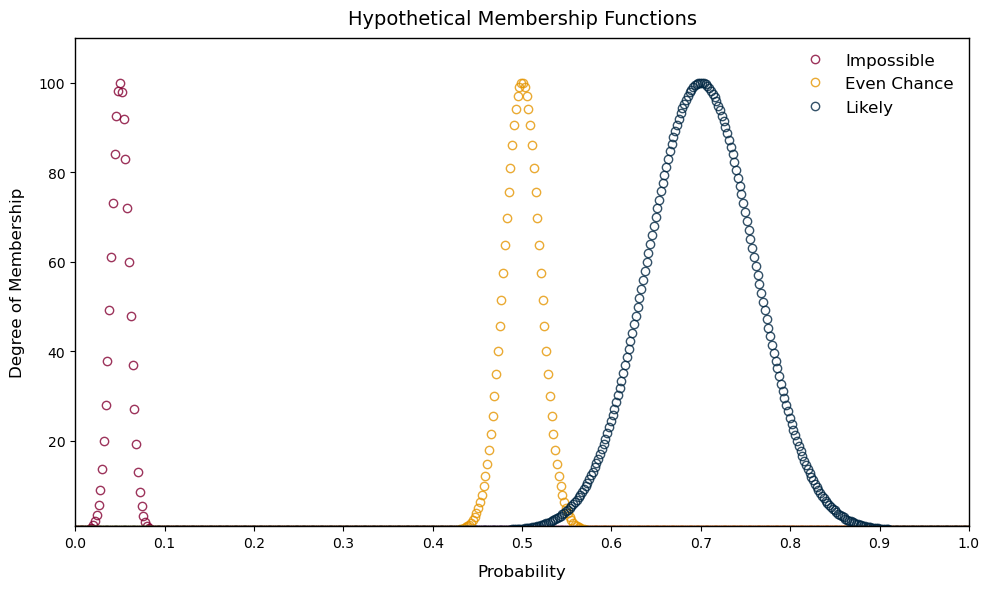

In [6]:
np.random.seed(444)
x = np.linspace(0, 1, 500)
likely = norm.pdf(x, loc=0.7, scale=0.06)
even_chance = norm.pdf(x, loc=0.5, scale=0.02)
impossible = norm.pdf(x, loc=0.05, scale=0.01)

# The membership degrees in Dhami & Madel (2022) range between 0 and 100
likely = 100*(likely-np.min(likely))/(np.max(likely)-np.min(likely))
even_chance = 100*(even_chance-np.min(even_chance))/(np.max(even_chance)-np.min(even_chance))
impossible = 100*(impossible-np.min(impossible))/(np.max(impossible)-np.min(impossible))

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.plot(x, impossible, marker="o", linestyle="None", markerfacecolor="None",
        color="#840032", label="Impossible", alpha=0.8)
ax.plot(x, even_chance, marker="o", linestyle="None", markerfacecolor="None",
        color="#e59500", label="Even Chance", alpha=0.8)
ax.plot(x, likely, marker="o", linestyle="None", markerfacecolor="None",
        color="#002642", label="Likely", alpha=0.8)

ax.set_facecolor("white")
ax.set_xlim(0, 1)
ax.set_ylim(0.9, 110)
ax.set_xlabel("Probability", labelpad=10, fontsize=12)
ax.set_ylabel("Degree of Membership", labelpad=10, fontsize=12)
ax.set_xticks(np.arange(0.0, 1.01, 0.1))
ax.set_xticklabels([f"{x:.1f}" for x in np.arange(0.0, 1.01, 0.1)])
ax.set_title("Hypothetical Membership Functions", pad=10, fontsize=14)
ax.legend(loc="upper right", frameon=False, fontsize=12)

# Styling: make the box visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color("black")

plt.tight_layout()
plt.savefig(graphics_path + "hypothetical_membership_functions" + graphics_format, dpi=600)
plt.show()

### Figure 2.3: Simulated Calibration Curves

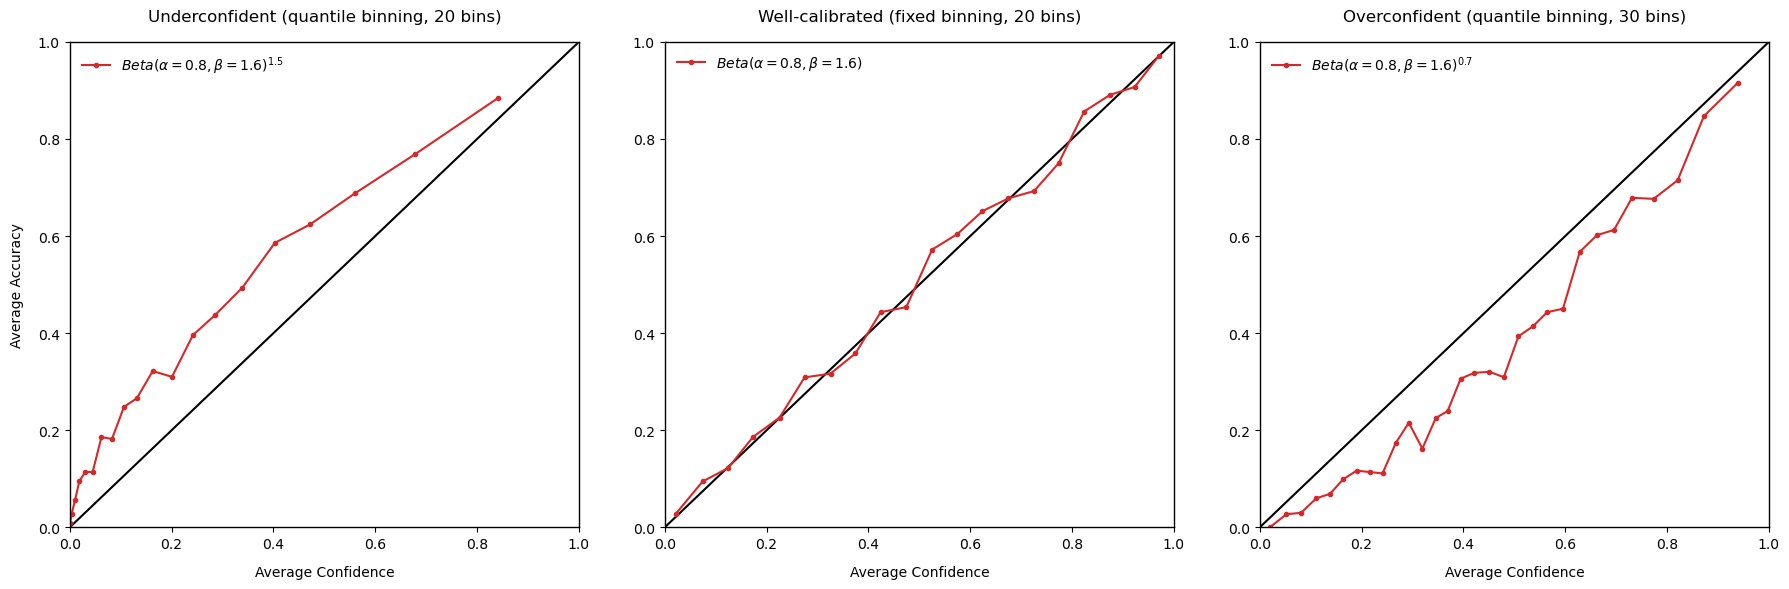

In [11]:
n = 10_000
np.random.seed(444)

# Idea from Arrieta-Ibarra (2022): draw probability distribution and
# use it as success probabilities for a bernoulli distribution
confs_well = beta.rvs(0.8, 1.6, size=n)   # Well-Calibrated
confs_under = confs_well**1.5             # Underconfident
confs_over = confs_well**0.7              # Overconfident
ground_truths = np.random.binomial(1, confs_well)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_calibration_curve("Underconfident (quantile binning, 20 bins)", [ground_truths], [confs_under], n_bins=20,
                       binning_strategy="quantile", colors=["#d62828"], linestyles=["solid"], markers=["."],
                       labels=[r"$Beta(\alpha=0.8, \beta=1.6)^{1.5}$"], axis=axs[0])
plot_calibration_curve("Well-calibrated (fixed binning, 20 bins)", [ground_truths], [confs_well], n_bins=20,
                       binning_strategy="uniform", colors=["#d62828"], linestyles=["solid"], markers=["."],
                       labels=[r"$Beta(\alpha=0.8, \beta=1.6)$"], axis=axs[1])
plot_calibration_curve("Overconfident (quantile binning, 30 bins)", [ground_truths], [confs_over], n_bins=30,
                       binning_strategy="quantile", colors=["#d62828"], linestyles=["solid"], markers=["."],
                       labels=[r"$Beta(\alpha=0.8, \beta=1.6)^{0.7}$"],  axis=axs[2])
axs[1].set_ylabel("")
axs[2].set_ylabel("")
plt.savefig(graphics_path + "calibration_curves_simulated" + graphics_format, dpi=600)
plt.show()

### Figure 3.1: Domains represented by the relations of BEAR

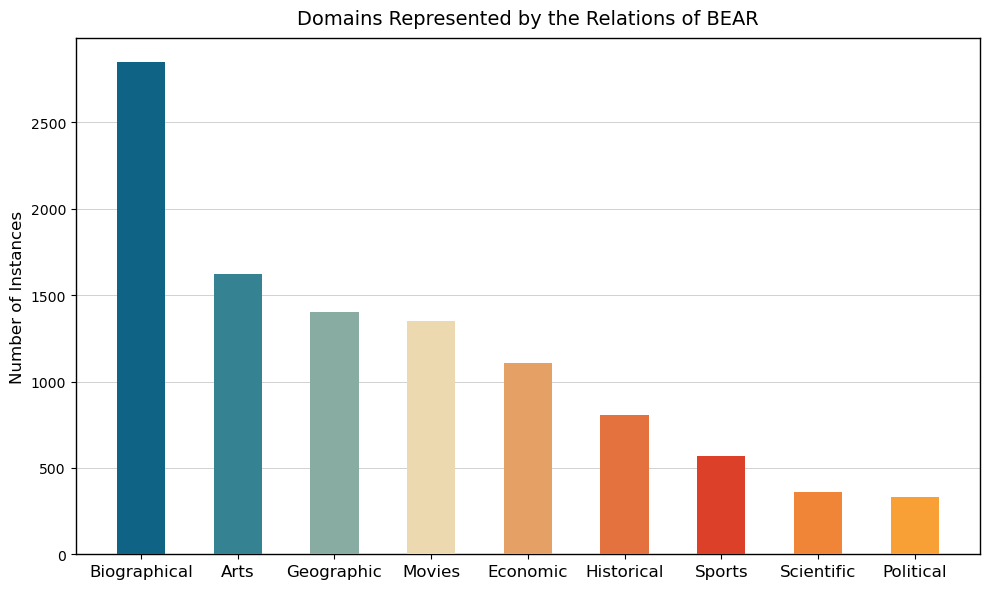

In [10]:
domain_sizes = (
    instance_lvl_results[instance_lvl_results["model"] == "gpt2"]
    .explode("domains")
    .groupby("domains")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
palette = ["#0f6385", "#358292", "#88aca2", "#ecd9af", "#e5a065",
           "#e4723e", "#dc4029", "#f08537", "#f8a036"]

_, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    domain_sizes["domains"],
    domain_sizes["count"],
    color=palette,
    width=0.5,
    zorder=3
)

ax.set_xlabel("")
ax.set_ylabel("Number of Instances", fontsize=12)
ax.set_title("Domains Represented by the Relations of BEAR", pad=10, fontsize=14)
ax.set_xticks(range(len(domain_sizes)))
ax.set_xticklabels(domain_sizes["domains"], ha="center", fontsize=12)

ax.set_facecolor("white")
ax.yaxis.grid(True, linestyle="solid", linewidth=0.5, color="gray", alpha=0.5)
ax.xaxis.grid(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color("black")

plt.tight_layout()
plt.savefig(graphics_path + "domain_sizes" + graphics_format, dpi=800)
plt.show()

### Table A.1: Accuracy Comparisons (BEAR score, First Template, Plurality & Majority Vote)

In [13]:
d = {
    "model": [],
    "bear_score": [],
    "first_template": [],
    "max_conf": [],
    "plurality_vote": [],
    "majority_vote": [],
    "pv_fails": [],
    "mv_fails": [],
    "pv_ties": []
}

for model in list_of_all_models:
    results = instance_lvl_results[instance_lvl_results["model"] == model]

    # Group by relation, count instances, compute means
    grouped = results.groupby("relation").agg({
        "instance": "count",
        "bear_score": "mean",
        "correctly_predicted": "mean",
        "plurality_correct": "mean",
        "majority_correct": "mean",
        "max_conf_correct": "mean"
    }).reset_index()

    d["model"].append(model)
    d["bear_score"].append(weighted_average(grouped, "bear_score"))
    d["first_template"].append(weighted_average(grouped, "correctly_predicted"))
    d["plurality_vote"].append(weighted_average(grouped, "plurality_correct"))
    d["majority_vote"].append(weighted_average(grouped, "majority_correct"))
    d["max_conf"].append(weighted_average(grouped, "max_conf_correct"))

    d["pv_fails"].append(results["plurality_fail"].sum())
    d["pv_ties"].append(results["plurality_tie"].sum())
    d["mv_fails"].append(results["majority_fail"].sum())
table_a1 = (
    pd.DataFrame(d)
    .sort_values("model")
    .set_index("model")
    .round(3)
    [["bear_score", "first_template", "max_conf", "plurality_vote", "majority_vote"]]*100
)

In [14]:
table_a1.to_latex(tables_path + "table_a1.txt", float_format="%.1f", header=True)

### Table A2. Voting comparisons (ties/fails)

In [15]:
table_a2 = pd.DataFrame(d).sort_values("model").set_index("model")[["pv_ties", "pv_fails", "mv_fails"]]
table_a2.to_latex(tables_path + "table_a2.txt", header=True)

### Mean absolute deviations to BEAR score

In [16]:
r = {
    "model": [],
    "first_template": [],
    "maximum_confidence": [],
    "plurality_vote": [],
    "majority_vote": []
}

for model in list_of_all_models:
    d = instance_lvl_results[instance_lvl_results["model"] == model]

    grouped = d.groupby("relation").agg({
        "instance": "count",
        "bear_score": "mean",
        "correctly_predicted": "mean",
        "plurality_correct": "mean",
        "majority_correct": "mean",
        "max_conf_correct": "mean"
    }).reset_index()

    weights = grouped["instance"]

    r["model"].append(model)
    r["first_template"].append(
        mean_absolute_error(grouped["bear_score"], grouped["correctly_predicted"], sample_weight=weights)
    )
    r["maximum_confidence"].append(
        mean_absolute_error(grouped["bear_score"], grouped["max_conf_correct"], sample_weight=weights)
    )
    r["plurality_vote"].append(
        mean_absolute_error(grouped["bear_score"], grouped["plurality_correct"], sample_weight=weights)
    )
    r["majority_vote"].append(
        mean_absolute_error(grouped["bear_score"], grouped["majority_correct"], sample_weight=weights)
    )

In [17]:
pd.DataFrame(r).round(3).set_index("model")*100

,first_template,maximum_confidence,plurality_vote,majority_vote
model,,,,
opt-350m,2.9,4.5,2.5,2.2
opt-125m,2.8,2.2,2.2,1.8
xlm-roberta-large,2.8,1.9,1.9,1.5
gpt2-medium,3.5,3.4,2.9,2.5
roberta-large,3.1,2.8,2.6,2.5
opt-6.7b,5.0,8.7,4.8,3.1
roberta-base,3.0,2.3,2.1,2.3
gemma-2b,6.0,9.4,6.0,3.8
xlm-roberta-base,1.8,1.7,1.4,1.5
